In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import numpy as np
from scipy import stats

mpl.rcParams.update({
    'font.size'           : 24.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'medium',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'large',
})


# Parameter Estimation & Sampling

### Morning: Estimating distribution parameters
- Review: moments of distributions
- Why estimate distributions?
- Method Of Moments (MOM)
- Maximum Likelihood Estimation (MLE)
- Maximum A Posteriori Estimation (MAP)
- Kernel Density Estimation (KDE)

### Afternoon: Sampling
- Population inference
- Central Limit Theorem (CLT)
- Confidence Intervals
- Bootstrapping

# Review: Moments of a Distribution

On probability day, we explored the following question: "Given a distribution for a random variable, what are the properties of data generated by the distribution?" Our tool was the expectation value.

### Mean: $\mu = E[X]$

#### Discrete random variable: $E[X] = \sum\limits_{\{x_i\}} x_i P(X=x_i)$

#### Continuous random variable: $E[X] = \int_{-\infty}^{\infty} x f(x) \,dx$

### Variance $\sigma^2 = E[(X - E[X])^2]$

#### Discrete: $\sigma^2 = \sum\limits_{\{x_i\}} (x_i-\mu)^2 P(X=x_i)$

#### Continuous: $\sigma^2 = \int_{-\infty}^{\infty} (x-\mu)^2 f(x) \,dx$

### In general, we can calculate expected values of arbitrary powers of X

#### nth raw moment: $\mu_n = E[X^n]$

#### nth central moment: $\mu'_n = E[(X - E[X])^n]$

# Estimating distributions

Today, we have the reverse question: "Given a set of observed data, what are the properties of the probability distribution function that generated it?"

### Why?
- Example 1: You have data on how many people order cakes every day at your bakery, and you want to estimate the probability of selling out.
- Example 2: You have data on how often your car breaks down, and you want to know your chances of safely crossing the country in it.
- Example 3: You have data on how many people visit your website each day, and you want to know the probability of your servers being overloaded.


## Method of Moments
- Assume an underlying distribution for your domain.
  - E.g. Poisson, Bernoulli, Binomial, Gaussian

- Compute the relevant moments of your sample.
  - E.g. Mean, Variance

- Derive the formula for your parameters of interest in terms of moments of the PMF/PDF of your assumed distribution

- Substitute the sample moments into the formula, and ta-da!

#### We use the sample moments to estimate the moments of the distribution.


### Example 1
- Your website visitor log shows the following number of visits for each of the last seven days: [6, 4, 7, 4, 9, 3, 5]. What’s the probability of zero visitors tomorrow?

#### Which underlying distribution should we assume? What are its parameters?
#### Which moment should we estimate?

In [2]:
data = np.array([6, 4, 7, 4, 9, 3, 5])

In [3]:
mu = np.mean(data)
var = np.var(data)

print("Sample mean: {:.3} \nSample variance: {:.3}".format(mu,var))

dist = stats.poisson(mu)

print("Poisson(mu): P(X=0)={:.3}".format(dist.pmf(0)))


Sample mean: 5.43 
Sample variance: 3.67
Poisson(mu): P(X=0)=0.00439


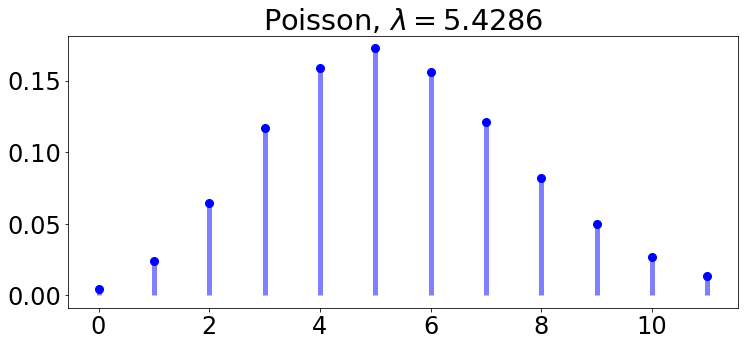

In [4]:
x = np.arange(dist.ppf(0.00001),
              dist.ppf(0.99))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, dist.pmf(x), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, dist.pmf(x), colors='b', lw=5, alpha=0.5)
ax.set_title("Poisson, $\lambda={:.4f}$".format(mu));

### Example 2
You flip a coin 100 times. It comes up heads 52 times. What’s the MOM estimate that in the next 100 flips the coin will be heads <= 45 times?

#### Which underlying distribution should we assume? What are its parameters?
#### Which moment should we estimate?

$\bar{x} = 52$, $\mu = np$

In [5]:
n = 100
p = 52/n
dist = stats.binom(n, p)
print(dist.cdf(45))

0.0966533503278


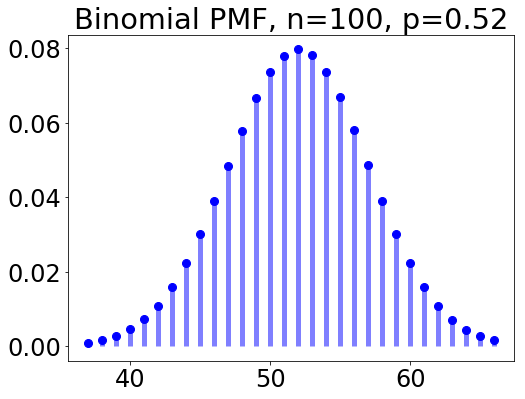

In [6]:
x = np.arange(dist.ppf(0.001),
              dist.ppf(0.999))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, dist.pmf(x), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, dist.pmf(x), colors='b', lw=5, alpha=0.5)
ax.set_title("Binomial PMF, n=100, p=0.52");

### Example 3

In [7]:
uniform_dist = stats.uniform(0,50)
data = uniform_dist.rvs(10, random_state=42)
print(data)

[ 18.72700594  47.53571532  36.59969709  29.93292421   7.80093202
   7.79972602   2.90418061  43.30880729  30.05575059  35.40362889]


If we assume that the above data are drawn from a continuous uniform distribution $U(0,b)$, what is the MOM estimate of b?

In [8]:
2*np.mean(data)

52.013673595267484

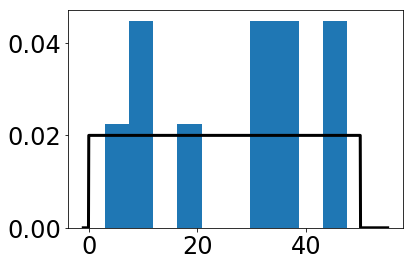

In [11]:
plt.hist(data, normed=True)
x = np.linspace(-1,55, 1000)
plt.plot(x, uniform_dist.pdf(x), 'k', linewidth=3);

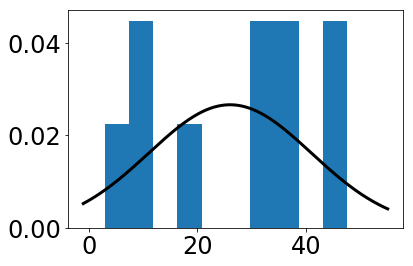

In [10]:
plt.hist(data, normed=True)
x = np.linspace(-1,55, 1000)
plt.plot(x, stats.norm(np.mean(data), np.std(data)).pdf(x), 'k', linewidth=3);

## Maximum Likelihood Estimation

Overview:
- Law of Likelihood:
   - If $P(X|H1) > P(X|H2)$, then the evidence supports H1 over H2.
- Question:
   - Which hypothesis does the evidence most strongly support?
- Answer:
   - The hypothesis H that maximizes P(X|H), which is found via MLE.

### MLE Steps:
- Assume an underlying distribution for your domain. (just like with MOM)
  - E.g. Poisson, Bernoulli, Binomial, Gaussian
- Define the likelihood function.
  - We want to know the likelihood of the data we observe under different distribution parameterizations.

- Choose the parameter set that maximizes the likelihood function.

### Defining the likelihood
Say we have a set of observations $\{x_1, x_2, \dots, x_n\}$

We assume some distribution and call its parameters $\theta$, so we write the probability density (or mass) function as $f(x;\theta)$

If $f(x;\theta)$ is a probability mass function, and each data point is _independent and identically drawn_ (i.i.d) from it, then we can say that the probability of observing our entire data set is the product of the probabilities of observing each data point
$$f(x_1, x_2, \dots, x_n | \theta) = f(x_1|\theta) f(x_2|\theta) \dots f(x_n|\theta)$$

(If the distribution is continuous, then this really represents a joint probability density instead of a joint probability. Our estimation process remains the same, however).

#### Likelihood function:
$\mathcal{L}(\theta ; x_1, x_2, \dots, x_n) = f(x_1, x_2, \dots, x_n | \theta) = \prod\limits_{i=1}^n f(x_i | \theta)$

We now want to find the value of $\theta$ that maximizes the likelihood function.

For computational ease (that is, to prevent underflow), we first take the log of the likelihood, then find the $\theta$ that maximizes that. 

$\hat{\theta}_{\text{mle}} = \arg\max_{\theta \in \Theta} \, \text{log}\left( \mathcal{L}(\theta | x_1, \dots, x_n) \right)$

### Example: Binomial

You flip a coin 100 times. It comes up heads 52 times. What’s the MLE estimate that in the next 100 flips the coin will be heads <= 45 times?

$$ 
\begin{align}
X_i \overset{iid}{\sim} \text{Bin}(n,p) \\
i = 1,2,\ldots,n \\
f(x_i \mid p) &= \binom{n}{k}p^{x_i} (1 - p)^{n - x_i} \\
\mathcal{L}(p) &= \prod\limits_{i=1}^n f(x_i \mid p) \\
\log{\mathcal{L}(p)} &= \sum\limits_{i=1}^n\left[\log\binom{n}{x_i} 
    + x_i\log p + (n - x_i)\log(1-p)\right] \\
\frac{\partial \log\mathcal{L}(p)}{\partial p} &= \sum\limits_{i=1}^n\left[ \frac{x_i}{p}
    - \frac{n - x_i}{1-p}\right] = 0 \\
\hat{p}_{MLE} &= \frac{\bar{x}}{n}
\end{align}
$$

### Example: Uniform(0, b)
$0 \leq X \leq b$

Given a set of observations $\{x_1, x_2, \dots, x_n\}$, what is the MLE estimate of b?

## Maximum A Posteriori estimation (MAP)

MLE finds $\theta$ that maximizes
$$f(x_1, x_2, \dots, x_n | \theta)$$

But we really want to know this:
$$f(\theta | x_1, x_2, \dots, x_n)$$

That is, we want the probability of a parameter given the data.

We can construct a formula for this using Bayes' Theorem

$$f(\theta | x) = \frac{ f(x|\theta) g(\theta) }{ \int_{\theta' \in \Theta} f(x|\theta') g(\theta') \,d\theta' } \propto f(x|\theta) g(\theta)$$


So now we maximize this:
$$\hat{\theta}_{\text{map}} = \arg\max_{\theta \in \Theta} \, f(x_1, x_2, \dots, x_n | \theta) g(\theta)$$

### CLT example: website revenue per visitor (see companion slides)

We have a website with ads and a product. Most users (90%) do nothing that generates revenue. Some click ads (7% do, causes a little revenue) and some (3%) buy our app!

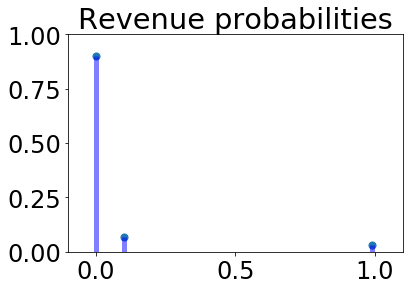

In [15]:
revenues = [0, 0.1, 0.99]
price_probs = [0.9, 0.07, 0.03]

plt.scatter(revenues, price_probs, s=50)
plt.vlines(revenues, 0, price_probs, colors='b', lw=5, alpha=0.5)
plt.axis([-0.1,1.1,0,1])
plt.title('Revenue probabilities');

In [16]:
n=100
print(np.random.choice(revenues, p=price_probs, size=n))

[ 0.    0.    0.1   0.1   0.    0.1   0.    0.    0.    0.    0.    0.    0.1
  0.    0.    0.    0.1   0.    0.    0.    0.1   0.    0.    0.    0.    0.1
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.    0.
  0.1   0.    0.    0.1   0.1   0.    0.99  0.1   0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.1   0.  ]


In [19]:
def generate_sample_means(sample_size, num_trials):
    means = np.empty(shape=num_trials)
    for i in range(num_trials):
        mean = np.mean(np.random.choice(revenues, p=price_probs, size=n))
        means[i] = mean
    return means

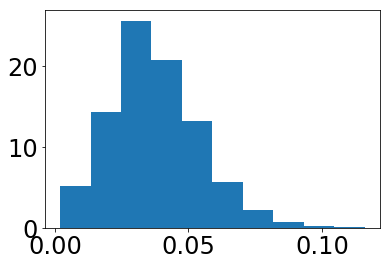

In [28]:
means = generate_sample_means(sample_size=1000, num_trials=10000)
plt.hist(means, normed=True);

### Start to a proof: 
let X be a random variable with an arbitrary distribution, and $\{X_1, X_2, X_3, \cdots, X_n\}$ be a sample of size $n$. Each data point can be considered an independent draw from the same distribution.

Now let Z be the average of those random variables: $Z = \frac{1}{n}\sum_i^n X_i$

$$E[Z] = E\left[\frac{1}{n}\sum_i^n X_i\right] = \frac{1}{n}\sum_i^n E[X_i] = \frac{1}{n} n E[X] = E[X]$$
$$Var[Z] = Var\left[\frac{1}{n}\sum_i^n X_i\right] = \frac{1}{n^2}\sum_i^n Var[X_i] = \frac{1}{n^2} n Var[X] = \frac{1}{n}Var[X]$$